In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [2]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [4]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### MLP


In [5]:
def mlp(units = [28*28,250,80,10]):
    seq = [torch.nn.Flatten()]
    for i in range(len(units)-2):
        seq.append(torch.nn.Linear(units[i],units[i+1]))
        seq.append(torch.nn.Sigmoid())
    seq.append(torch.nn.Linear(units[-2],units[-1]))
    return torch.nn.Sequential(*seq)

In [6]:
model = mlp()
from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 250]         196,250
           Sigmoid-3                  [-1, 250]               0
            Linear-4                   [-1, 80]          20,080
           Sigmoid-5                   [-1, 80]               0
            Linear-6                   [-1, 10]             810
Total params: 217,140
Trainable params: 217,140
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.83
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


### Training

Implement the training / evaluation loop

Remember training / validation cost and accuracy per epoch. 

In [7]:
def train_eval(model, optimizer, nepochs, training_loader, test_loader, scheduler=None):
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    cost_ce = torch.nn.CrossEntropyLoss()
        
    for epoch in range(nepochs):
        model.train()
        size = len(training_loader.dataset)
        nbatches = len(training_loader)
        size_test = len(test_loader.dataset)
        nbatches_test = len(test_loader)
        cost, acc = 0.0, 0.0
        for batch, (X, Y) in enumerate(training_loader):
            pred = model(X)
            loss = cost_ce(pred, Y)
            cost += loss.item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

            # gradient, parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if scheduler:
            scheduler.step()
        cost /= nbatches
        acc /= size
    
        model.eval()
        cost_test, acc_test = 0.0, 0.0        
        with torch.no_grad():
            for X, Y in test_loader:
                pred = model(X)
                cost_test += cost_ce(pred, Y).item()
                acc_test += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
        cost_test /= nbatches_test
        acc_test /= size_test
        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. SGD: Revisit plain SGD (without momentum) and try different learning rates (lr). Create suitable comparison plots (learning curves with the train and validate cost and accuracy) for (~3) different learning rates. Describe in words what you see. What is a reasonable number of epochs (nepochs)? What is your recommended best choice (lr, nepochs) for the given problem?

2. Momentum: Play with different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?

3. RMSprop: Same thing now for RMSprop (without momentum). Play with different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?

4. Adam: Same thing now for Adam. Play with different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?

5. Learning rate schedule: Implement a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task? Note the way how the scheduler is incorporated into the `train_eval`-method above.


In [26]:
nbatch = 64
nepochs = 50
lr = [0.2, 0.3, 0.5, 0.8]
for i, lr in enumerate(lr):
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

    model = mlp()
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
    cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, validation_loader)
    plt.plot(torch.arange(nepochs), cost_hist, color=f"C{0}", linestyle="--", label=f"train lr={lr}")
    plt.plot(torch.arange(nepochs), cost_hist_test, color=f"C{0}", label=f"valid lr = {lr}")
    plt.legend()

Epoch 0: 1.338951, 0.499540, 0.859586, 0.674600
Epoch 1: 0.669756, 0.748660, 0.627127, 0.761700
Epoch 2: 0.551924, 0.800340, 0.559684, 0.800000
Epoch 3: 0.503645, 0.818500, 0.513940, 0.817600
Epoch 4: 0.467261, 0.830060, 0.503493, 0.815700
Epoch 5: 0.444152, 0.838880, 0.454942, 0.840900
Epoch 6: 0.427240, 0.845180, 0.510896, 0.818300
Epoch 7: 0.412727, 0.851400, 0.514451, 0.805400
Epoch 8: 0.402185, 0.854380, 0.449992, 0.840500
Epoch 9: 0.392111, 0.857040, 0.419637, 0.851400
Epoch 10: 0.381216, 0.861620, 0.407288, 0.854300
Epoch 11: 0.373614, 0.865140, 0.561977, 0.813200
Epoch 12: 0.365021, 0.867180, 0.402616, 0.857000
Epoch 13: 0.355663, 0.871500, 0.404722, 0.852000
Epoch 14: 0.350660, 0.872140, 0.368336, 0.869100
Epoch 15: 0.345127, 0.874760, 0.454991, 0.836800
Epoch 16: 0.337335, 0.877960, 0.369782, 0.867100
Epoch 17: 0.333319, 0.877420, 0.355269, 0.871300
Epoch 18: 0.325388, 0.882240, 0.371774, 0.868800
Epoch 19: 0.321798, 0.882300, 0.412330, 0.847500
Epoch 20: 0.318354, 0.883600, 


KeyboardInterrupt



### Plots and Comments (for the different steps described above) 

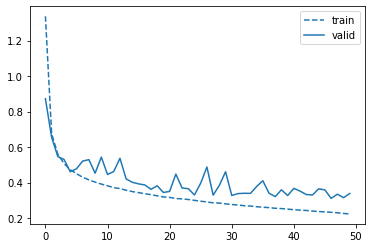